In [1]:
import os
import csv
import re
import json
from datetime import datetime
import seaborn as sns

In [2]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.models import Model
from keras.layers import Activation
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.inception_v3 import decode_predictions
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from keras.models import model_from_json
import itertools
import matplotlib.pyplot as plt
import time
import pandas as pd
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

In [4]:
clean_dataDirectory = "data/results/cleaned_data.csv"
standard_dataDirectory = "data/results/standardized_data.csv"
data = pd.read_csv(standard_dataDirectory)
# print(data.head(5))
data = data.dropna()

In [5]:
collum_list = data['num_bedrooms'][data['num_bedrooms'] >= 0]
# print(collum_list.mean())
data['num_bedrooms'] = data['num_bedrooms'].apply(lambda x: int(collum_list.mean()) if x < 0 else x)
data['num_bedrooms']

0         4
1         6
2         3
3        20
4         4
         ..
14605     6
14606     4
14607    10
14608    10
14609     6
Name: num_bedrooms, Length: 14601, dtype: int64

In [6]:
collum_list = data['num_bathrooms'][data['num_bathrooms'] >= 0]
# print(collum_list.mean())
data['num_bathrooms'] = data['num_bathrooms'].apply(lambda x: int(collum_list.mean()) if x < 0 else x)
data['num_bathrooms']

0         4
1         4
2         4
3        21
4         5
         ..
14605     6
14606     3
14607     9
14608     4
14609     6
Name: num_bathrooms, Length: 14601, dtype: int64

In [7]:
collum_list = data['num_floors'][data['num_floors'] >= 0]
# print(collum_list.mean())
data['num_floors'] = data['num_floors'].apply(lambda x: int(collum_list.mean()) if x < 0 else x)
data['num_floors']

0        8
1        5
2        5
3        9
4        5
        ..
14605    6
14606    4
14607    6
14608    7
14609    5
Name: num_floors, Length: 14601, dtype: int64

In [8]:
collum_list = data['entrance'][data['entrance'] >= 0]
# print(collum_list.mean())
data['entrance'] = data['entrance'].apply(lambda x: int(collum_list.mean()) if x < 0 else x)
data['entrance']

0         6.0
1         6.0
2         6.0
3         6.0
4         4.0
         ... 
14605     5.0
14606     3.0
14607     2.0
14608    40.0
14609     8.0
Name: entrance, Length: 14601, dtype: float64

In [9]:
collum_list = data['frontage'][data['frontage'] >= 0]
# print(collum_list.mean())
data['frontage'] = data['frontage'].apply(lambda x: int(collum_list.mean()) if x < 0 else x)
data['frontage']

0         5.4
1         5.0
2         5.0
3         5.0
4         3.4
         ... 
14605     3.8
14606     5.5
14607     3.5
14608    15.0
14609     5.2
Name: frontage, Length: 14601, dtype: float64

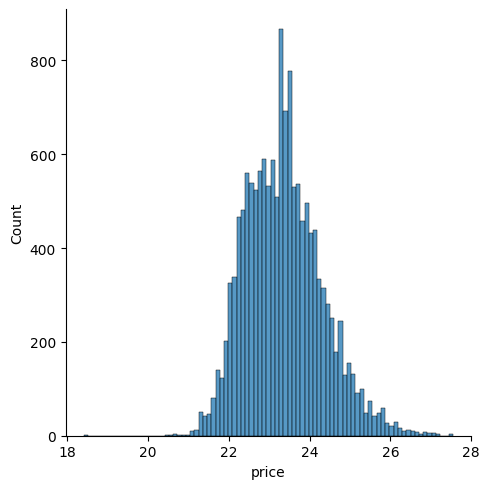

In [10]:
sns.displot(np.log(data['price']))
data['log_price'] = np.log(data['price'])

In [11]:
clean_train_data = data.drop(['price', 'price_per_sqm', 'log_price', 'pr_id', 'posted_date'], axis=1)
clean_train_label = data['log_price']
train_data, test_data, train_label, test_label = train_test_split(clean_train_data, clean_train_label, test_size=0.2, random_state=42)

In [12]:
RF = RandomForestRegressor()
RF.fit(train_data, train_label)

RandomForestRegressor()

In [14]:
predict = RF.predict(test_data)
print(test_label)

print(predict)

169      24.124463
9357     21.932226
3013     23.556479
1475     22.974558
7422     23.814308
           ...    
740      22.640188
3461     23.397414
5183     24.800803
1188     23.191365
13096    24.251096
Name: log_price, Length: 2921, dtype: float64
[24.08584869 22.10402887 23.33645819 ... 24.37171509 23.19840503
 24.27912189]
